In [1]:
using VCFTools
using Plots
using DelimitedFiles
using Statistics
using LaTeXStrings

## HRC

In [2]:
"""
Computes r2 for SNPs that have minor allele counts between a certain range specified in `maf_bins`.
"""
function compute_r2_by_maf(
    minor_allele_count::AbstractVector,
    Xtrue::AbstractMatrix,
    Xtest::AbstractMatrix;
    verbose::Bool = false
    )
#     maf_bins = [(1, 1), (2, 2), (4, 4), (14, 18), (70, 90), (300, 500), (1500, 2500)] # min/max
    maf_bins = [(1, 1), (2, 2), (4, 4), (7, 9), (14, 18), (30, 34), (60, 68), (120, 130),
        (250, 260), (500, 520), (1000, 1100), (2000, 2100), (4000, 4100), 
        (8100, 8200), (16300, 16500), (24000, 25000)] # min/max
    r2 = zeros(length(maf_bins))
    xtrue = Vector{Vector{Float64}}()
    ximpute = Vector{Vector{Float64}}()
    for (i, mac) in enumerate(maf_bins)
        idx = findall(x -> mac[1] ≤ x ≤ mac[2], minor_allele_count)
        for j in idx
            push!(xtrue, @view(Xtrue[:, j]))
            push!(ximpute, @view(Xtest[:, j]))
        end
        r2[i] = abs2(cor(vcat(xtrue...), vcat(ximpute...)))
        verbose && println("macbin = $mac has $(length(idx)) matches and r2 = $(r2[i])")
    end
    return r2
end

compute_r2_by_maf

## Chromosome 20

In [3]:
chr = 20
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.chr$chr.imputed.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue")
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel")
Xbeagle = convert_ds(Float32, beagle, msg="importing Xbeagle")
Xmmac4 = convert_ds(Float32, mmac4, msg="importing Xmmac")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 4 : 14
Ximp5 = Vector{Matrix{Float32}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_ds(Float32, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks")
end
Ximp5 = hcat(Ximp5...);

importing Xtrue100%|████████████████████████████████████| Time: 0:02:00
importing Xmendel100%|██████████████████████████████████| Time: 0:01:09
importing Xbeagle100%|██████████████████████████████████| Time: 0:03:26
importing Xmmac100%|████████████████████████████████████| Time: 0:03:28
importing Ximp5 1 / 4100%|██████████████████████████████| Time: 0:01:08
importing Ximp5 2 / 4100%|██████████████████████████████| Time: 0:00:55
importing Ximp5 3 / 4100%|██████████████████████████████| Time: 0:01:10
importing Ximp5 4 / 4100%|██████████████████████████████| Time: 0:00:12


macbin = (1, 1) has 6371 matches and r2 = 0.005898138814568548
macbin = (2, 2) has 5579 matches and r2 = 0.01832857079499368
macbin = (4, 4) has 21810 matches and r2 = 0.07591194875514064
macbin = (7, 9) has 85586 matches and r2 = 0.09624505565090384
macbin = (14, 18) has 56310 matches and r2 = 0.22847486442440337
macbin = (30, 34) has 17175 matches and r2 = 0.680392857287213
macbin = (60, 68) has 14520 matches and r2 = 0.7583641161964992
macbin = (120, 130) has 6940 matches and r2 = 0.7870589656217062
macbin = (250, 260) has 2702 matches and r2 = 0.8174859375659742
macbin = (500, 520) has 1608 matches and r2 = 0.8326300438928721
macbin = (1000, 1100) has 3258 matches and r2 = 0.8773604446759425
macbin = (2000, 2100) has 1581 matches and r2 = 0.90630217629982
macbin = (4000, 4100) has 971 matches and r2 = 0.9194369402716533
macbin = (8100, 8200) has 549 matches and r2 = 0.9302129856112523
macbin = (16300, 16500) has 841 matches and r2 = 0.9481890766336938
macbin = (24000, 25000) has 36

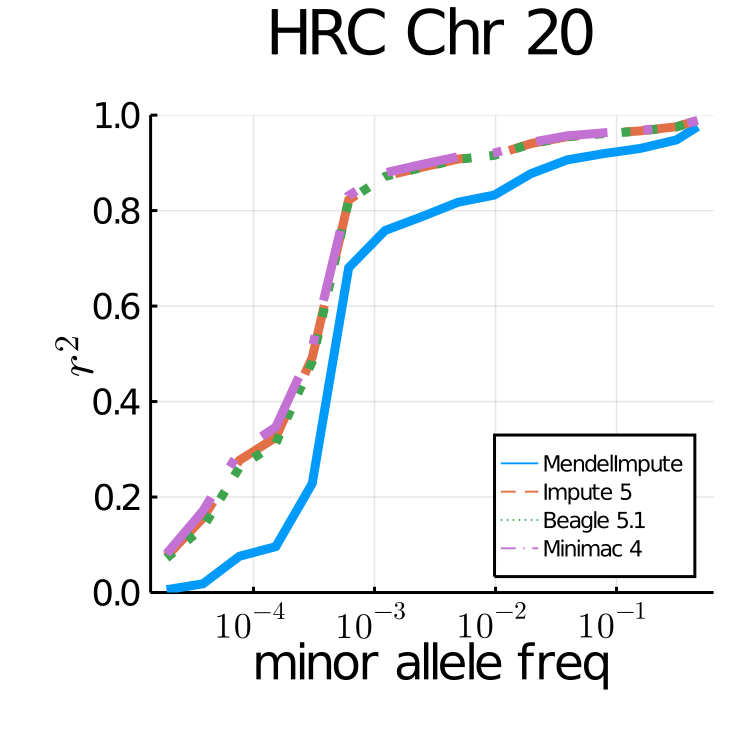

In [4]:
chr = 20
mafs = vec(readdlm("chr$chr.maf"))
n = nsamples("ref.chr$chr.excludeTarget.vcf.gz")
minor_allele_count = mafs .* 2n
maf_bins = [2^i for i in 0:14]
push!(maf_bins, 24500)
xticks = ([1e-4, 1e-3, 1e-2, 1e-1], [latexstring("\$10^{-4}\$"),
    latexstring("\$10^{-3}\$"),latexstring("\$10^{-2}\$"), latexstring("\$10^{-1}\$")])

r2_mendel = compute_r2_by_maf(minor_allele_count, Xtrue, Xmendel, verbose=true)
r2_impute5 = compute_r2_by_maf(minor_allele_count, Xtrue, Ximp5)
r2_beagle5 = compute_r2_by_maf(minor_allele_count, Xtrue, Xbeagle)
r2_mimimac4 = compute_r2_by_maf(minor_allele_count, Xtrue, Xmmac4)
sleep(1)

chr20_plt = plot(maf_bins ./ 2n, r2_mendel,label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="minor allele freq", ylabel=latexstring("\$r^2\$"), xaxis=:log, linestyle=:solid,
    xtick=xticks, dpi=300, size=(250, 250), ylim=(0, 1),
    title="HRC Chr 20", legendfontsize=5)
plot!(maf_bins ./ 2n, r2_impute5, label="Impute 5", lw = 3, linestyle=:dash, legendfontsize=5)
plot!(maf_bins ./ 2n, r2_beagle5, label="Beagle 5.1", lw = 3, linestyle=:dot, legendfontsize=5)
plot!(maf_bins ./ 2n, r2_mimimac4, label="Minimac 4", lw = 3, linestyle=:dashdot, legendfontsize=5)

savefig(chr20_plt, "chr$chr.maf_plt.png")
display("image/png", read("chr$chr.maf_plt.png"))

## Chromosome 10

Note: this requires at least 33GB of free RAM to run

In [3]:
chr = 10
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.chr$chr.imputed.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue")
n, p = size(Xtrue)
@show n, p
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel")
Xbeagle = convert_ds(Float16, beagle, msg="importing Xbeagle")
Xmmac4 = convert_ds(Float16, mmac4, msg="importing Xmmac")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 4 : 14
Ximp5 = Vector{Matrix{Float16}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_ds(Float16, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks")
end
Ximp5 = hcat(Ximp5...);


importing Xtrue100%|████████████████████████████████████| Time: 0:02:29


(n, p) = (1000, 1920530)


importing Xmendel100%|██████████████████████████████████| Time: 0:02:28
importing Xbeagle100%|██████████████████████████████████| Time: 0:07:16
importing Xmmac100%|████████████████████████████████████| Time: 0:07:26
importing Ximp5 1 / 14100%|█████████████████████████████| Time: 0:00:39
importing Ximp5 2 / 14100%|█████████████████████████████| Time: 0:00:37
importing Ximp5 3 / 14100%|█████████████████████████████| Time: 0:00:34
importing Ximp5 4 / 14100%|█████████████████████████████| Time: 0:00:30
importing Ximp5 5 / 14100%|█████████████████████████████| Time: 0:00:19
importing Ximp5 6 / 14100%|█████████████████████████████| Time: 0:00:31
importing Ximp5 7 / 14100%|█████████████████████████████| Time: 0:00:33
importing Ximp5 8 / 14100%|█████████████████████████████| Time: 0:00:31
importing Ximp5 9 / 14100%|█████████████████████████████| Time: 0:00:33
importing Ximp5 10 / 14100%|████████████████████████████| Time: 0:00:31
importing Ximp5 11 / 14100%|████████████████████████████| Time: 

macbin = (1, 1) has 13577 matches and r2 = 0.012158814068147708
macbin = (2, 2) has 11564 matches and r2 = 0.024848521265815653
macbin = (4, 4) has 45188 matches and r2 = 0.0822422781889301
macbin = (7, 9) has 180887 matches and r2 = 0.1341234272419233
macbin = (14, 18) has 123820 matches and r2 = 0.27775902152761595
macbin = (30, 34) has 38296 matches and r2 = 0.45309456588773783
macbin = (60, 68) has 30689 matches and r2 = 0.7862853682014536
macbin = (120, 130) has 15269 matches and r2 = 0.8645056464738045
macbin = (250, 260) has 5636 matches and r2 = 0.888920295409529
macbin = (500, 520) has 3762 matches and r2 = 0.9066526958832618
macbin = (1000, 1100) has 6881 matches and r2 = 0.9235087692967568
macbin = (2000, 2100) has 3705 matches and r2 = 0.9383086534540501
macbin = (4000, 4100) has 2306 matches and r2 = 0.9474832706898122
macbin = (8100, 8200) has 1490 matches and r2 = 0.9546656494519499
macbin = (16300, 16500) has 1957 matches and r2 = 0.964571048181724
macbin = (24000, 2500

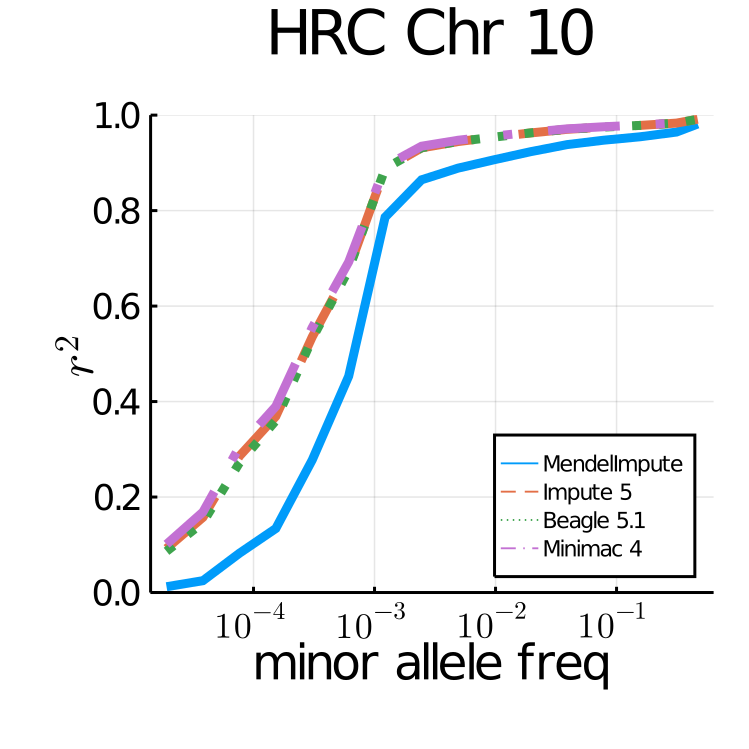

In [4]:
chr = 10
mafs = vec(readdlm("chr$chr.maf"))
n = nsamples("ref.chr$chr.excludeTarget.vcf.gz")
minor_allele_count = mafs .* 2n
maf_bins = [2^i for i in 0:14]
push!(maf_bins, 24500)
xticks = ([1e-4, 1e-3, 1e-2, 1e-1], [latexstring("\$10^{-4}\$"),
    latexstring("\$10^{-3}\$"),latexstring("\$10^{-2}\$"), latexstring("\$10^{-1}\$")])

r2_mendel = compute_r2_by_maf(minor_allele_count, Xtrue, Xmendel, verbose=true)
r2_impute5 = compute_r2_by_maf(minor_allele_count, Xtrue, Ximp5)
r2_beagle5 = compute_r2_by_maf(minor_allele_count, Xtrue, Xbeagle)
r2_mimimac4 = compute_r2_by_maf(minor_allele_count, Xtrue, Xmmac4)
sleep(1)

chr20_plt = plot(maf_bins ./ 2n, r2_mendel,label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="minor allele freq", ylabel=latexstring("\$r^2\$"), xaxis=:log, linestyle=:solid,
    xtick=xticks, dpi=300, size=(250, 250), ylim=(0, 1),
    title="HRC Chr 10", legendfontsize=5)
plot!(maf_bins ./ 2n, r2_impute5, label="Impute 5", lw = 3, linestyle=:dash, legendfontsize=5)
plot!(maf_bins ./ 2n, r2_beagle5, label="Beagle 5.1", lw = 3, linestyle=:dot, legendfontsize=5)
plot!(maf_bins ./ 2n, r2_mimimac4, label="Minimac 4", lw = 3, linestyle=:dashdot, legendfontsize=5)

savefig(chr20_plt, "chr$chr.maf_plt.png")
display("image/png", read("chr$chr.maf_plt.png"))